# FALTA BALANCEAR EL DATASET

# Importing libraries

In [132]:
import time
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
import numpy as np

from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from category_encoders import BinaryEncoder

# Importing data and proccessing them

### Input

In [133]:
df = pd.read_csv("train_data.csv")
features = ["risk"] #Array!! Time features that you want to analyze
timestep = 7 #from 1 to 23 (17 with the current NaN strategy)
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

In [134]:
#Dropping first the empty column and then rows with NaNs
df = df.drop("c_rcs_estimate", axis=1)
df = df.dropna(how='any')

#Filtering events with len=1 or min_tca > 2 or max_tca < 2
def conditions(event):
    x = event["time_to_tca"].values
    return ((x.min()<2.0) & (x.max()>2.0) & (x.shape[0]>1))

df = df.groupby('event_id').filter(conditions)

#OHE for c_object_type (5 categories) -> 5 new features
df = pd.get_dummies(df)

#Binary encoder for mission_id (19 categories) -> 5 new features
encoder = BinaryEncoder(cols=['mission_id'], drop_invariant=True)
df = encoder.fit_transform(df)

#Getting y as 1D-array
y = df.groupby(["event_id"])["risk"].apply(lambda x: x.iloc[-1]).values.reshape(-1, 1)

#Scaling y
_ = y_scaler.fit(df["risk"].values.reshape(-1, 1)) #using the whole risk feature to scale the target 'y'
y = y_scaler.transform(y)

#Getting X as df (dropping rows with tca < 2) 
df = df.loc[df["time_to_tca"]>2]

#Adding feature 'event_length' for counting how many instances each event has
df["event_length"] = df.groupby('event_id')['event_id'].transform('value_counts')

#Scaling X
df = pd.DataFrame(X_scaler.fit_transform(df), columns=df.columns)

#Shifting features
features.append('event_id')
X = pd.DataFrame()

for feature in features:
    for i in range(timestep-1,-1,-1):
        X[feature+'_t-'+str(i)] = df[feature].shift(i)
    
#Getting last row -> getting one row per event
X = X.groupby(["event_id_t-0"]).apply(lambda x: x.iloc[-1])
X = X.reset_index(drop=True)

#Deleting rows with more than one event_id
for i in range(timestep):
    X = X.loc[X["event_id_t-0"]==X["event_id_t-"+str(i)]]

#Dropping y values not included in X due to last condition
y = np.take(y, X.index)
y = y.reshape(-1, 1)

#Deleting event_id features
event_features = [feature for feature in list(X.columns) if feature.startswith('event_id_t-')]
X = X.drop(event_features, axis=1)

print(X.shape, y.shape)

#TODO: not dropping y values bc of X but filling X with zeros

(6019, 770) (6019, 1)


# Filter: Univariate Selection
https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

/home/sergio/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Feature,Score,p-values
48,risk_t-0,2837.516180,0.000000e+00
47,risk_t-1,2116.794763,0.000000e+00
46,risk_t-2,1552.691347,2.594387e-302
45,risk_t-3,1239.687625,4.254002e-247
335,c_time_lastob_start_t-0,1173.031164,4.963729e-235
342,c_time_lastob_end_t-0,1015.411586,4.825835e-206
334,c_time_lastob_start_t-1,968.515868,2.719304e-197
44,risk_t-4,963.948876,1.949091e-196
341,c_time_lastob_end_t-1,925.596647,3.128526e-189
340,c_time_lastob_end_t-2,859.774327,9.034522e-177


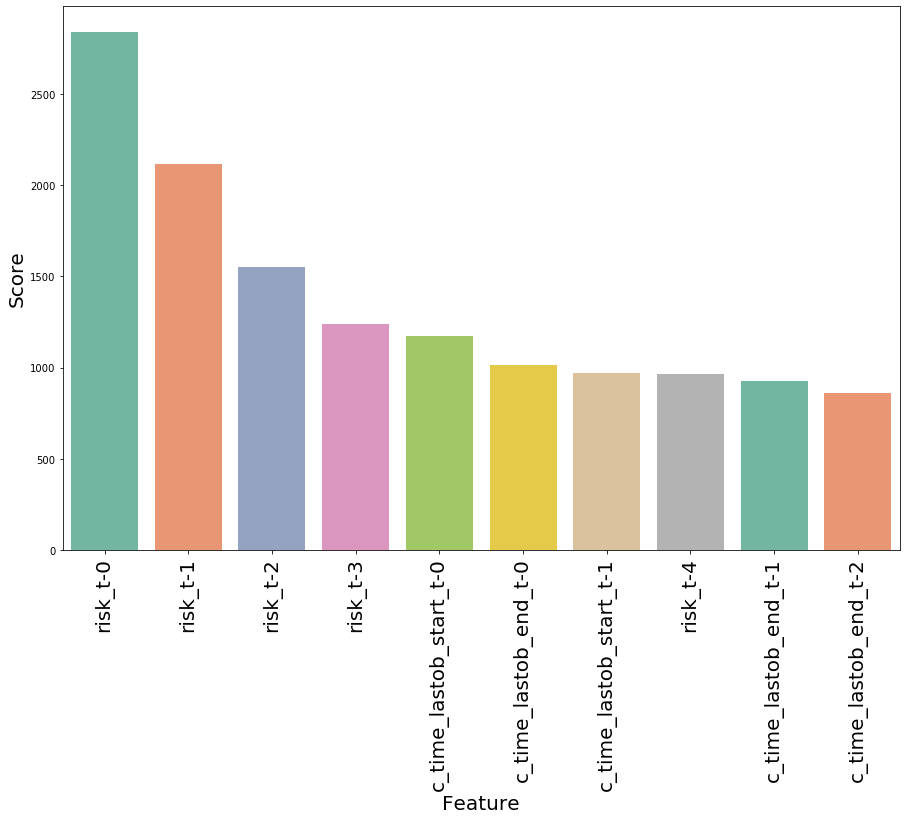

In [135]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

score_func = f_regression
k = 3
show_df = 100
show_plot = 10

#Applying SelectKBest to extract the 10 best features
bestfeatures = SelectKBest(score_func=score_func, k=k)
fit = bestfeatures.fit(X,y)

#Concatenating dataframes for better visualization
dfscores = pd.DataFrame(fit.scores_)
dfpvalues = pd.DataFrame(fit.pvalues_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores, dfpvalues],axis=1)
featureScores.columns = ['Feature','Score',"p-values"]

#Printing and plotting the best features
feature_sorted = featureScores.sort_values("Score",ascending=False)
display(feature_sorted.head(show_df))

for col in ["Score"]: #,"p-values"]:
    plt.figure(figsize=(15,10))
    ax = sns.barplot(x='Feature', y=col, data=feature_sorted.iloc[:show_plot], palette="Set2")
    ax.set_xticklabels(feature_sorted['Feature'],rotation=90, fontsize=20)
    ax.set_xlabel("Feature",fontsize=20)
    ax.set_ylabel(col,fontsize=20)
    plt.show

# Wrapper: Recursive Feature Elimination

In [136]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

model = LinearRegression()
n_features_to_select = 5
step = 10
show_df = 20

rfe_selector = RFE(estimator=model,
                   n_features_to_select=n_features_to_select,
                   step=step
                  )
rfe_selector.fit(X, y)

rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
ranking = sorted(zip(rfe_selector.ranking_, X.columns))

print("Top features:")
for feature in ranking[:show_df]:
    print(feature)

/home/sergio/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Top features:
(1, 'mission_id_4_t-4')
(1, 'mission_id_4_t-6')
(1, 't_h_per_t-1')
(1, 't_j2k_sma_t-1')
(1, 't_j2k_sma_t-6')
(2, 'mission_id_3_t-4')
(2, 't_h_apo_t-1')
(2, 't_h_apo_t-6')
(2, 't_h_per_t-6')
(2, 't_j2k_sma_t-2')
(3, 'mission_id_2_t-0')
(3, 'mission_id_2_t-5')
(3, 'mission_id_3_t-1')
(3, 'mission_id_3_t-2')
(3, 'mission_id_4_t-0')
(3, 'mission_id_4_t-1')
(3, 'mission_id_4_t-2')
(3, 't_h_apo_t-2')
(3, 't_h_per_t-2')
(3, 't_j2k_sma_t-4')


# Wrapper: CV-RFE

In [129]:
#RFE with CV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

model = LinearRegression()
k_fold = 3

#SVC IS REALLY SLOW!!!
# Creating the RFE object and computing a cross-validated score.
rfecv = RFECV(estimator=model,
              step=1,
              cv=StratifiedKFold(k_fold),
              scoring='accuracy',
              verbose=1,
             )
rfecv.fit(X, y)

rfe_support = rfecv.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
ranking = sorted(zip(rfecv.ranking_, X.columns))

print(rfe_feature)

print("Optimal number of features: %d" % rfecv.n_features_)
print("Top features:")
for feature in ranking[:rfecv.n_features_]:
    print(feature)

plt.figure(figsize=(15,10))
sns.set()
ax = sns.lineplot(x=range(1, len(rfecv.grid_scores_) + 1), y=rfecv.grid_scores_, palette="Set2")
ax.set_xlabel('Number of Features',fontsize=20)
ax.set_ylabel('CV Score (Accuracy)',fontsize=20)

plt.show()

/home/sergio/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: Supported target types are: ('binary', 'multiclass'). Got 'continuous' instead.

# Embedded: Feature Importance
https://towardsdatascience.com/the-5-feature-selection-algorithms-every-data-scientist-need-to-know-3a6b566efd2

/home/sergio/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/sergio/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


,Feature,Importance
48,risk_t-0,0.216310
47,risk_t-1,0.069393
335,c_time_lastob_start_t-0,0.030544
342,c_time_lastob_end_t-0,0.030405
61,max_risk_scaling_t-1,0.013032
340,c_time_lastob_end_t-2,0.007067


<function matplotlib.pyplot.show(*args, **kw)>

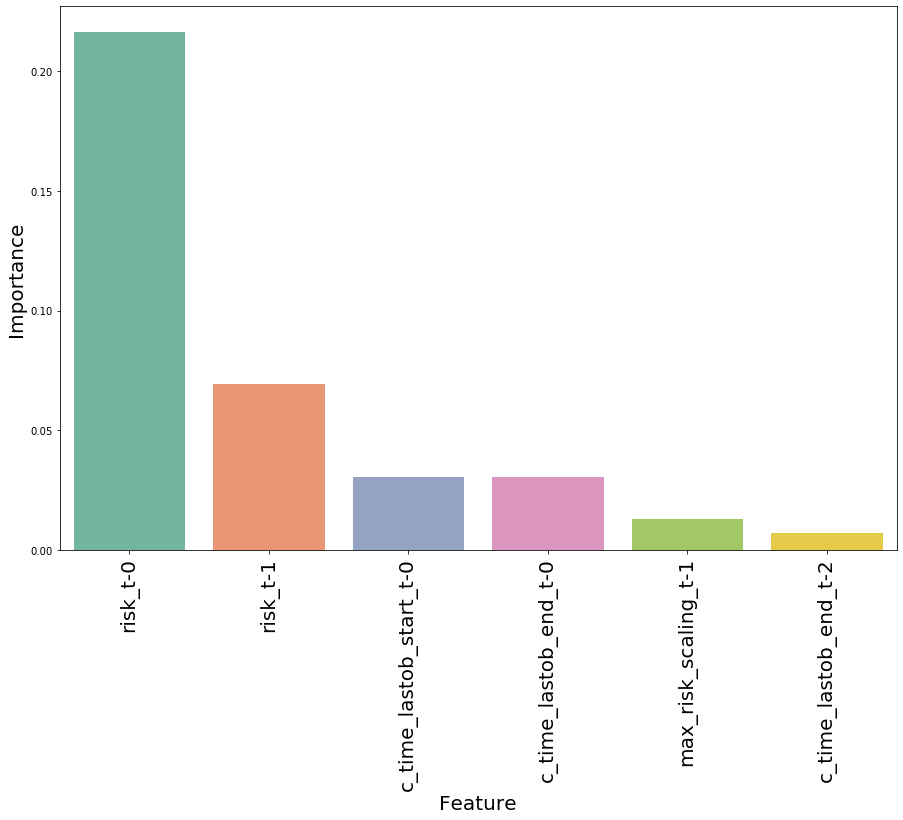

In [137]:
from sklearn.ensemble import ExtraTreesRegressor

model = ExtraTreesRegressor()
show_df = 6
show_plot = 6

#Using inbuilt class feature_importances of tree based classifiers
model.fit(X,y)

#Creating dataset of feature importances for better visualization
dfimportance = pd.DataFrame(model.feature_importances_)
dfcolumns = pd.DataFrame(X.columns)
feat_importances = pd.concat([dfcolumns,dfimportance],axis=1)
feat_importances.columns = ['Feature','Importance']

#Displaying it
df_sort = feat_importances.sort_values("Importance",ascending=False)
display(df_sort.head(show_df))

plt.figure(figsize=(15,10))
ax = sns.barplot(x='Feature', y='Importance', data=df_sort.iloc[:show_plot], palette="Set2")
ax.set_xticklabels(df_sort['Feature'],rotation=90, fontsize=20)
ax.set_xlabel('Feature',fontsize=20)
ax.set_ylabel('Importance',fontsize=20)
plt.show

# Embedded: Select from Model

In [138]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge

model = Ridge()
max_features = 3 

embeded_lr_selector = SelectFromModel(model,
                                      max_features=max_features)
embeded_lr_selector.fit(X, y)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
for feature in embeded_lr_feature:
    print(feature)

risk_t-0
max_risk_scaling_t-2
c_obs_used_t-5
